In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random

from copy import deepcopy

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

import Preprocessor
import Parameters
import HHMM
import Visualisor

rand_seed = 0

random.seed(rand_seed)
np.random.seed(rand_seed)

# Initialize parameters

In [2]:
date = '17-06-2021'

hmm_FV_num = 1
hhmm_FV_uncorr_num = 501
hhmm_V_num = 1001
hhmm_FV_num = 1501

In [3]:
### initialize parameters ####
ndives = 100
ndatasets = 1

# train new models?
train_new = False

#model = 'CarHMM'
#model = 'HHMM'
#model = 'CarHHMM1'
#model = 'CarHHMM2'
model = 'all'

# number of states for each substate
K0 = 2
K1 = 3

# dive duration parameters
dd_mu = np.array([27.34,127.55])
dd_sig = np.array([10.96,63.89])

dd_shape = np.square(dd_mu)/np.square(dd_sig)
dd_scale = np.square(dd_sig)/np.array(dd_mu)

# FoVeDBA parameters (this is for the SQUARE of the FoVeDBA)

# make shape decay like 1/n
FoVeDBA_sin_shape = np.array([[(1.0/n**3) for n in range(1,52)] for _ in range(K1)])
for i in range(K1):
    FoVeDBA_sin_shape[i,:] = FoVeDBA_sin_shape[i,:]/sum(FoVeDBA_sin_shape[i,1:11])

# scale needs to be constant
FoVeDBA_sin_scale = np.ones((K1,51))

# set mean and variance
FoVeDBA_mu = np.array([[34.01],[490.06],[9154.16]])
FoVeDBA_sig = np.array([[22.99],[502.56],[13538.75]])

# adjust shape and scale accordingly
FoVeDBA_sin_shape *= np.square(FoVeDBA_mu)/np.square(FoVeDBA_sig)
FoVeDBA_sin_scale *= np.square(FoVeDBA_sig)/FoVeDBA_mu

# average acceleration parameters
acc_mu = np.array([0.0,0.1,0.2])
acc_sig = np.array([0.05,0.1,0.3])

# intialize correlation within states
corr_crude = [0.0,0.0,0.0]
corr_fine = [0.97,0.83,0.61]

# initialize a probablity transition matrix

eta_crude = np.array([[ 0.    , -1.7127],
                      [ 2.3629,  0.    ]])

ptm_crude = HHMM.eta_2_ptm(eta_crude)
print(ptm_crude)

eta_fine =  [np.array([[  0.    ,  -1.078 , -5.9046],
                       [ -2.3897,   0.    , -2.819 ],
                       [ -10.000,  -1.2166,  0.    ]]),
              np.array([[  0.    ,  -2.0510,  -10.000],
                        [ -1.6947,   0.    ,  -3.1301],
                        [ -10.000,  -1.2369,   0.    ]])]

ptm_fine = [HHMM.eta_2_ptm(eta_fine[0]),
            HHMM.eta_2_ptm(eta_fine[1])]

print(ptm_fine)

[[0.84718616 0.15281384]
 [0.91395414 0.08604586]]
[array([[7.44600380e-01, 2.53369190e-01, 2.03043016e-03],
       [7.96103234e-02, 8.68566173e-01, 5.18235032e-02],
       [3.50232147e-05, 2.28527337e-01, 7.71437640e-01]]), array([[8.86012983e-01, 1.13946792e-01, 4.02249272e-05],
       [1.49632674e-01, 8.14751737e-01, 3.56155895e-02],
       [3.51847950e-05, 2.24968131e-01, 7.74996684e-01]])]


In [18]:
FoVeDBA_sin_shape[0,1]

1.3796190898903387

In [17]:
FoVeDBA_sin_shape[0,0]/(2**3)

1.3796190898903387

In [4]:
print(sum(FoVeDBA_sin_shape[0,1:11]))
print(np.sqrt(sum(FoVeDBA_sin_shape[0,1:11]))*FoVeDBA_sin_scale[0,0])

print(sum(FoVeDBA_sin_shape[1,1:11]))
print(np.sqrt(sum(FoVeDBA_sin_shape[1,1:11]))*FoVeDBA_sin_scale[1,0])

2.1884434123352228
22.99
0.9508733447752917
502.56000000000006


In [5]:
# initialize the initial states
delta_crude = np.ones(K0)/K0
for _ in range(100):
    delta_crude = delta_crude.dot(ptm_crude)
    
delta_fines = []
for k0 in range(K0):
    delta_fine = np.ones(K1)/K1
    for _ in range(100):
        delta_fine = delta_fine.dot(ptm_fine[k0])
    delta_fines.append(delta_fine)

# Create Data 

In [6]:
def create_data():

    data = []
    data_V = []
    data_FV = []
    freqs = np.fft.rfftfreq(100, d=1/50.0)
    thresh = 5
    thresh_ind = max(np.where(freqs <= thresh)[0]) + 1

    time = 0

    for dive_num in range(ndives):

        # select dive type
        if dive_num == 0:
            dive_type = np.random.choice(K0,p=delta_crude)
            dd_mu_t = np.copy(dd_mu[dive_type])
        else:
            dive_type_tm1 = dive_type
            dive_type = np.random.choice(K0,p=ptm_crude[dive_type,:])
            dd_mu_t = np.copy(dd_mu[dive_type])
            dd_mu_t = corr_crude[dive_type]*dd_tm1 + (1.0-corr_crude[dive_type])*dd_mu_t

        # select dive duration
        dd_sig_t = dd_sig[dive_type]
        dd_shape_t = np.square(dd_mu_t)/np.square(dd_sig_t)
        dd_scale_t = np.square(dd_sig_t)/np.array(dd_mu_t)

        dive_duration = gamma.rvs(dd_shape_t,0,dd_scale_t)
        dd_tm1 = dive_duration
        datum = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_V = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_FV = {'dive_type': dive_type, 'dive_duration': dive_duration}
        nsegs = int(dive_duration/2.0)

        subdive_features = []
        subdive_features_V = []
        subdive_features_FV = []

        for seg_num in range(nsegs):

            seg = {}
            seg_V = [{},{}]
            seg_FV = {}

            # find seg type
            if seg_num == 0:
                subdive_type = np.random.choice(K1,p=delta_fines[dive_type])
                FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
                acc_mu_t = np.copy(acc_mu[subdive_type])
            else:
                subdive_type = np.random.choice(K1,p=ptm_fine[dive_type][subdive_type,:])
                FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
                acc_mu_t = np.copy(acc_mu[subdive_type])
                acc_mu_t = corr_fine[subdive_type]*acc_tm1 + (1.0-corr_fine[subdive_type])*acc_mu_t

            seg['subdive_type'] = subdive_type
            seg_FV['subdive_type'] = subdive_type
            seg_V[0]['subdive_type'] = subdive_type
            seg_V[1]['subdive_type'] = subdive_type

            # find average acceleration
            acc_sig_t = acc_sig[subdive_type]

            # find FoVeDBA
            FoVeDBA_sin_sig2_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]**2
            FoVeDBA_sin_shape_t = np.square(FoVeDBA_sin_mu_t)/FoVeDBA_sin_sig2_t
            FoVeDBA_sin_scale_t = FoVeDBA_sin_sig2_t/FoVeDBA_sin_mu_t
            FoVeDBA_sin = gamma.rvs(FoVeDBA_sin_shape_t,0,FoVeDBA_sin_scale_t)
            FoVeDBA_sin_tm1 = np.copy(FoVeDBA_sin)

            seg['FoVeDBA_full'] = FoVeDBA_sin.T
            seg['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001
            seg_FV['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001

            # find VeDBA
            pm = (2*np.random.choice(2,size = FoVeDBA_sin.shape)-1)
            FoVeDBA = pm*np.sqrt(FoVeDBA_sin)*1.0j
            A = np.array(np.fft.irfft(FoVeDBA))
            V0 = norm.rvs(acc_mu_t,acc_sig_t)
            acc_tm1 = V0
            A += np.linspace(V0,V0,100).T

            seg['A'] = A
            seg['avg_A'] = np.mean(A)
            seg_V[0]['A'] = np.mean(A[:50])
            seg_V[1]['A'] = np.mean(A[50:])
            seg_FV['A'] = np.mean(A)

            # find time
            seg['time'] = np.arange(time,time+2,1/50)
            time += 2

            subdive_features.append(seg)
            subdive_features_V.append(seg_V[0])
            subdive_features_V.append(seg_V[1])
            subdive_features_FV.append(seg_FV)

        datum['subdive_features'] = subdive_features
        datum_V['subdive_features'] = subdive_features_V
        datum_FV['subdive_features'] = subdive_features_FV

        data.append(datum)
        data_V.append(datum_V)
        data_FV.append(datum_FV)

    return data,data_V,data_FV

data,data_V,data_FV = create_data()

In [14]:
print(sum(FoVeDBA_sin_shape[0][1:11])*FoVeDBA_sin_scale[0][0])
print(np.sqrt(sum(FoVeDBA_sin_shape[0][1:11]))*FoVeDBA_sin_scale[0][0])
#print(FoVeDBA_sin_scale)

34.01
22.99


0.07862444471265297
0.22466571753914816
[46.50268809]


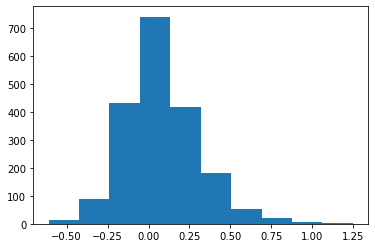

In [7]:
As = []
for dive in data_FV:
    As.extend([seg['A'] for seg in dive['subdive_features']])
plt.hist(As)
print(np.mean(As))
print(np.std(As))
print(np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))]))

# Visualize Data 

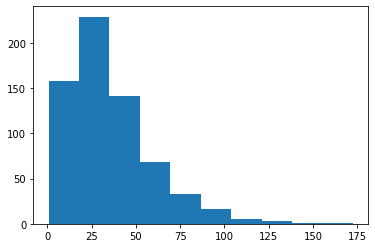

35.234232708641954
23.9158803501459


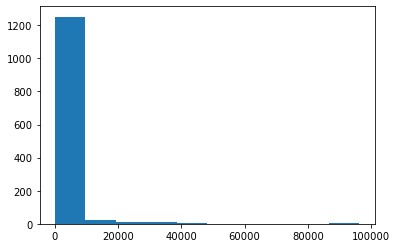

1756.813528333785
6226.231170678652

[  34.01  490.06 9154.16]
[   22.99   502.56 13538.75]


In [8]:
FO0 = []
FO1 = []
for dive in data_FV:
    for seg in dive['subdive_features']:
        if seg['subdive_type'] == 0:
            FO0.append(seg['FoVeDBA'])
        else:
            FO1.append(seg['FoVeDBA'])
        
plt.hist(FO0)
plt.show()
print(np.mean(FO0))
print(np.std(FO0))
plt.hist(FO1)
plt.show()
print(np.mean(FO1))
print(np.std(FO1))

print('')

print(FoVeDBA_sin_scale[:,0]*np.sum(FoVeDBA_sin_shape[:,1:11],1))
print(np.sqrt(((FoVeDBA_sin_scale[:,0]**2)*np.sum(FoVeDBA_sin_shape[:,1:11],1))))

# Find intial thetas for training

In [9]:
### CarHMM ###
hmm_FV_theta = [{'dive_duration': {'mu': np.array([np.mean(dd_mu)]),
                                   'sig': np.array([np.sqrt(np.mean(dd_sig**2) + np.var(dd_mu))]),
                                   'corr': np.array([-10.])}},
                 [{'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                               'sig': FoVeDBA_sig.flatten(),
                               'corr': np.array([ -10. for _ in range(K1)])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

eta_fine_temp = eta_fine[0]/2 + eta_fine[1]/2

hmm_FV_eta = [np.array([[0]]),
             [eta_fine_temp]]


### CarHHMM, no Z2 ###
hhmm_V_theta = [{'dive_duration': {'mu': dd_mu,
                                   'sig': dd_sig,
                                   'corr': np.array([ -10. for _ in range(K0)])}},
                 [{'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}},
                  {'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

hhmm_V_eta = [eta_crude,eta_fine]


### HHMM ###
hhmm_FV_uncorr_theta = [{'dive_duration': {'mu': dd_mu,
                                           'sig': dd_sig,
                                           'corr': np.array([ -10. for _ in range(K0)])}},
                         [{'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                                       'sig': FoVeDBA_sig.flatten(),
                                       'corr': np.array([ -10. for _ in range(K1)])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([ -10. for _ in range(K1)])}},
                          {'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                                       'sig': FoVeDBA_sig.flatten(),
                                       'corr': np.array([ -10. for _ in range(K1)])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([ -10. for _ in range(K1)])}}]]

hhmm_FV_uncorr_eta = [eta_crude,eta_fine]

### CarHHMM ###
hhmm_FV_theta = [{'dive_duration': {'mu': dd_mu,
                                    'sig': dd_sig,
                                    'corr': np.array([ -10. for _ in range(K0)])}},
                 [{'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                               'sig': FoVeDBA_sig.flatten(),
                               'corr': np.array([ -10. for _ in range(K1)])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}},
                 {'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                               'sig': FoVeDBA_sig.flatten(),
                               'corr': np.array([ -10. for _ in range(K1)])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

hhmm_FV_eta = [eta_crude,eta_fine]

# Try to relearn generative parameters many times

In [10]:
pars = Parameters.Parameters()
pars.K = [2,3]
pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA':{'corr':False,'f':'gamma'},
                  'A':{'corr':True,'f':'normal'}}]

hhmm_FV = HHMM.HHMM(pars,data_FV)
hhmm_FV.theta = deepcopy(hhmm_FV_theta)
hhmm_FV.eta = deepcopy(hhmm_FV_eta)
hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)

In [11]:
hhmm_FV.theta

[{'dive_duration': {'mu': array([ 27.34, 127.55]),
   'sig': array([10.96, 63.89]),
   'corr': array([-10., -10.])}},
 [{'FoVeDBA': {'mu': array([  34.01,  490.06, 9154.16]),
    'sig': array([   22.99,   502.56, 13538.75]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0. , 0.1, 0.2]),
    'sig': array([0.05, 0.1 , 0.3 ]),
    'corr': array([3.47609869, 1.58562726, 0.44731222])}},
  {'FoVeDBA': {'mu': array([  34.01,  490.06, 9154.16]),
    'sig': array([   22.99,   502.56, 13538.75]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0. , 0.1, 0.2]),
    'sig': array([0.05, 0.1 , 0.3 ]),
    'corr': array([3.47609869, 1.58562726, 0.44731222])}}]]

In [12]:
datasets = []
datasets_V = []
datasets_FV = []

hmm_FVs = []
hhmm_Vs = []
hhmm_FV_uncorrs = []
hhmm_FVs = []

h = 0.001

for dataset_num in [-1]:


    ### generate training data ###
    print('')
    print('GENERATING DATA')
    print('')
    data,data_V,data_FV = create_data()

    for dive in data_FV:
        print(dive['dive_type'])
        print(dive['dive_duration'])
        for seg in dive['subdive_features']:
            print(seg)
            
    ### generate test data ###
    data_test,data_V_test,data_FV_test = create_data()


    ### CarHMM ###
    if model in ['CarHMM','all']:
        print('')
        print('STARTING CarHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [1,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':True,'f':'normal'}}]
        pars.theta = hmm_FV_theta

        hmm_FV = HHMM.HHMM(pars,data_FV)
        hmm_FV.theta = hmm_FV_theta
        hmm_FV.eta = hmm_FV_eta
        hmm_FV.true_theta = deepcopy(hmm_FV_theta)
        hmm_FV.true_eta = deepcopy(hmm_FV_eta)
        
        if not train_new:
            hmm_FV = hmm_FV.load('../../Params/sims/%s/hmm_FV_0_%d'%(date,hmm_FV_num))
        else:
            print("training new %s"%model)
            hmm_FV.train_DM(data_FV,max_iters=10,max_steps=10)
            hmm_FV.get_SEs(data_FV,h)
            
        hmm_FV.reorder_params()

        # make test data
        for dive_num,datum in enumerate(data_FV_test):
            _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
            for i,post in enumerate(posts.T):
                data_test[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
                data_test[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post

        # get confusion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data_test:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hmm_FV_dive']
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hmm_FV_dive'])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hmm_FV_subdive'][k]

        hmm_FV.CM = [CM_coarse,CM_fine]

        # save data
        hmm_FV.save('../../Params/sims/local/hmm_FV_%d_%d'%(dataset_num,rand_seed))


    ### HHMM ###
    if model in ['HHMM','all']:
        print('')
        print('STARTING HHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [K0,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':False,'f':'normal'}}]

        hhmm_FV_uncorr = HHMM.HHMM(pars,data_FV)
        hhmm_FV_uncorr.theta = hhmm_FV_uncorr_theta
        hhmm_FV_uncorr.eta = hhmm_FV_uncorr_eta
        hhmm_FV_uncorr.true_theta = deepcopy(hhmm_FV_uncorr_theta)
        hhmm_FV_uncorr.true_eta = deepcopy(hhmm_FV_uncorr_eta)

        if not train_new:
            hhmm_FV_uncorr = hhmm_FV_uncorr.load('../../Params/sims/%s/hhmm_FV_uncorr_0_%d'%(date,hhmm_FV_uncorr_num))
        else:
            print("training new %s"%model)
            hhmm_FV_uncorr.train_DM(data_FV,max_iters=10,max_steps=10)
            hhmm_FV_uncorr.get_SEs(data_FV,h)
        
        hhmm_FV_uncorr.reorder_params()
        
        # crude posterior
        _,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV_test,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_FV_test):
            data_test[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,:]
            _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = np.array([posts_crude.T[dive_num,0]*post_fine_0[k] + \
                              posts_crude.T[dive_num,1]*post_fine_1[k] for k in range(K1)])
                data_test[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
                data_test[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,:]

        # get confusion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data_test:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_uncorr_dive'][1]
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_uncorr_dive'][1])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hhmm_FV_uncorr_subdive'][k]

        hhmm_FV_uncorr.CM = [CM_coarse,CM_fine]

        hhmm_FV_uncorr.save('../../Params/sims/local/hhmm_FV_uncorr_%d_%d'%(dataset_num,rand_seed))


    ### CarHHMM, no Z2 ###
    if model in ['CarHHMM1','all']:
        print('')
        print('STARTING CarHHMM minux Z2')
        print('')
        pars = Parameters.Parameters()
        pars.K = [K0,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'A':{'corr':True,'f':'normal'}}]

        hhmm_V = HHMM.HHMM(pars,data_V)
        hhmm_V.theta = hhmm_V_theta
        hhmm_V.eta = hhmm_V_eta
        hhmm_V.true_theta = deepcopy(hhmm_V_theta)
        hhmm_V.true_eta = deepcopy(hhmm_V_eta)

        if not train_new:
            hhmm_V = hhmm_V.load('../../Params/sims/%s/hhmm_V_0_%d'%(date,hhmm_V_num))
        else:
            print("training new %s"%model)
            hhmm_V.train_DM(data_V,max_iters=10,max_steps=10)
            hhmm_V.get_SEs(data_V,h)
            
        hhmm_V.reorder_params()

        # crude posterior
        _,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V_test,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_V_test):
            data_test[dive_num]['hhmm_v'] = posts_crude.T[dive_num,:]
            _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = np.array([posts_crude.T[dive_num,0]*post_fine_0[k] + \
                              posts_crude.T[dive_num,1]*post_fine_1[k] for k in range(K1)])
                if i%2 == 0:
                    p0 = p
                else:
                    data_test[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
                    data_test[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,:]

        # get confustion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data_test:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_V_dive'][1]
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_V_dive'][1])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hhmm_V_subdive'][k]

        hhmm_V.CM = [CM_coarse,CM_fine]
        hhmm_V.save('../../Params/sims/local/hhmm_V_%d_%d'%(dataset_num,rand_seed))


    ### CarHHMM ###
    if model in ['CarHHMM2','all']:
        print('')
        print('STARTING CarHHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [K0,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':True,'f':'normal'}}]

        hhmm_FV = HHMM.HHMM(pars,data_FV)
        hhmm_FV.theta = hhmm_FV_theta
        hhmm_FV.eta = hhmm_FV_eta
        hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
        hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)

        if not train_new:
            hhmm_FV = hhmm_FV.load('../../Params/sims/%s/hhmm_FV_0_%d'%(date,hhmm_FV_num))
        else:
            print("training new %s"%model)
            hhmm_FV.train_DM(data_FV,max_iters=10,max_steps=10)
            hhmm_FV.get_SEs(data_FV,h)
            
        hhmm_FV.reorder_params()

        # crude posterior
        _,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV_test,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_FV_test):
            _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = [posts_crude.T[dive_num,0]*post_fine_0[k] + \
                     posts_crude.T[dive_num,1]*post_fine_1[k] for k in range(K1)]
                data_test[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
                data_test[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,:]

        # get confusion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data_test:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_dive'][1]
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_dive'][1])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hhmm_FV_subdive'][k]

        hhmm_FV.CM = [CM_coarse,CM_fine]

        # save hmms
        hhmm_FV.save('../../Params/sims/local/hhmm_FV_%d_%d'%(dataset_num,rand_seed))


GENERATING DATA

0
25.551751785588166
{'subdive_type': 2, 'FoVeDBA': 72.80426599275678, 'A': 0.4927554616366416}
{'subdive_type': 1, 'FoVeDBA': 766.5744948942315, 'A': 0.26939145442741114}
{'subdive_type': 1, 'FoVeDBA': 1334.9801100338123, 'A': 0.35733040909059954}
{'subdive_type': 1, 'FoVeDBA': 68.67496906033398, 'A': 0.2905499289276558}
{'subdive_type': 1, 'FoVeDBA': 468.95210068256176, 'A': 0.3183765644646081}
{'subdive_type': 1, 'FoVeDBA': 1791.986861665077, 'A': 0.20425010675584163}
{'subdive_type': 1, 'FoVeDBA': 183.89408157498949, 'A': 0.08025258910572904}
{'subdive_type': 1, 'FoVeDBA': 165.6850486460352, 'A': 0.04399181246356958}
{'subdive_type': 0, 'FoVeDBA': 54.301715712991204, 'A': 0.002259287336683951}
{'subdive_type': 1, 'FoVeDBA': 1249.9690736081297, 'A': -0.022917790298795208}
{'subdive_type': 1, 'FoVeDBA': 163.1311565212416, 'A': 0.04876948684540405}
{'subdive_type': 1, 'FoVeDBA': 38.19294534561823, 'A': 0.005025100854470511}
0
13.41022640356129
{'subdive_type': 1, 'Fo

{'subdive_type': 1, 'FoVeDBA': 1328.264191275374, 'A': -0.0031708590080513697}
{'subdive_type': 1, 'FoVeDBA': 518.8196470493662, 'A': 0.15528904794823817}
{'subdive_type': 1, 'FoVeDBA': 65.25086416584332, 'A': 0.22579916137658404}
{'subdive_type': 0, 'FoVeDBA': 16.341862964368186, 'A': 0.1536740853027953}
{'subdive_type': 0, 'FoVeDBA': 12.613366206874437, 'A': 0.13799487442004835}
{'subdive_type': 0, 'FoVeDBA': 34.0439979296016, 'A': 0.0995717761009351}
{'subdive_type': 0, 'FoVeDBA': 54.765941664174115, 'A': 0.113167238255705}
{'subdive_type': 0, 'FoVeDBA': 27.827365845393793, 'A': 0.05221729091229601}
{'subdive_type': 0, 'FoVeDBA': 49.87516712556129, 'A': -0.012945218991705}
{'subdive_type': 0, 'FoVeDBA': 30.698445791444, 'A': 0.011277520196909283}
{'subdive_type': 0, 'FoVeDBA': 44.28474321805771, 'A': 0.08845806368591241}
{'subdive_type': 0, 'FoVeDBA': 37.42484824715119, 'A': 0.14369892539252319}
{'subdive_type': 0, 'FoVeDBA': 15.616085122248766, 'A': 0.1587189772070981}
{'subdive_ty


STARTING CarHMM


STARTING HHMM


STARTING CarHHMM minux Z2


STARTING CarHHMM



In [28]:
dive_colors = [cm.get_cmap('tab10')(i) for i in range(K0)]
dive_legend = ['Dive Type %d' % (i+1) for i in range(K0)]

subdive_colors = [cm.get_cmap('viridis')(i/(K1-1.0)) for i in range(K1)]
subdive_legend = ['Subdive Behavior %d' % (i+1) for i in range(K1)]

def plot_col(col,data,color,level,ax,legend=False,size=16,s_dive=0,e_dive=6):

    dive_starts = []
    dive_types = []
    subdive_starts = []
    subdive_types = []
    
    if color == 'dive':
        x = [list([]) for _ in range(K0+1)]
        y = [list([]) for _ in range(K0+1)]
    else:
        x = [list([]) for _ in range(K1+1)]
        y = [list([]) for _ in range(K1+1)]
    
    for datum in data[s_dive:e_dive]:
        dive_type = datum['dive_type']
        dive_types.append(dive_type)
        dive_starts.append(datum['subdive_features'][0]['time'][0])

        for seg in datum['subdive_features']:
            subdive_type = seg['subdive_type']
            
            subdive_types.append(subdive_type)
            subdive_starts.append(seg['time'][0])
            
            if col not in seg:
                continue
            
            if level == 0:
                seg_data = seg[col]
                if type(seg_data) in [list,np.ndarray]:
                    if 'subdive' in col:
                        seg_data = seg_data[subdive_type]
                    else:
                        seg_data = seg_data[dive_type]
                seg_data = [seg_data]*len(seg['time'])
            else:
                seg_data = seg[col]
            
            x[-1].extend(seg['time'])
            y[-1].extend(seg_data)
            if color == 'dive':
                x[dive_type].extend(seg['time'])
                y[dive_type].extend(seg_data)
            else:
                x[subdive_type].extend(seg['time'])
                y[subdive_type].extend(seg_data)
                
    dive_starts.append(data[e_dive]['subdive_features'][0]['time'][0])
    subdive_starts.append(data[e_dive]['subdive_features'][0]['time'][0])

    if color == 'dive':
        c = dive_colors
        l = dive_legend
        c0 = subdive_colors
        labels = ['Dive Type 1','Dive Type 2','Subdive State 1','Subdive State 2','Subdive State 3']
        legend_elements = [Patch(facecolor=c0[0], alpha=0.5, label=labels[2]),
                           Patch(facecolor=c0[1], alpha=0.5, label=labels[3]),
                           Patch(facecolor=c0[2], alpha=0.5, label=labels[4]),
                           Line2D([0], [0], marker='o', color='w', label=labels[0],
                                          markerfacecolor=c[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label=labels[1],
                                          markerfacecolor=c[1], markersize=8)]
    else:
        c = subdive_colors
        l = subdive_legend
        c0 = dive_colors
        labels = ['Subdive State 1','Subdive State 2','Subdive State 3','Dive Type 1','Dive Type 2']
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                          markerfacecolor=c[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label=labels[1],
                                          markerfacecolor=c[1], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label=labels[2],
                                          markerfacecolor=c[2], markersize=8),
                           Patch(facecolor=c0[0], alpha=0.5, label=labels[3]),
                           Patch(facecolor=c0[1], alpha=0.5, label=labels[4])]

    if color == 'dive':
        for state in range(K0):
            ax.plot(x[state],y[state],'.',color=c[state],markersize=2)
    else:
        for state in range(K1):
            ax.plot(x[state],y[state],'.',color=c[state],markersize=2)        
    
    if legend:
        leg = ax.legend(handles=legend_elements,prop={'size': size},ncol=2, mode="expand", borderaxespad=0.,
                        bbox_to_anchor=(0., 1., 1., .102), loc='lower left')
        
    ax.plot(x[-1],y[-1],'k--',linewidth=0.5,alpha=0.5, rasterized=True)
    
    if color == 'subdive':
        for i in range(e_dive-s_dive):
            ax.axvspan(dive_starts[i],dive_starts[i+1],
                       facecolor=dive_colors[dive_types[i]],
                       alpha = 0.1, rasterized=True)
    else:
        for i in range(len(subdive_starts)-1):
            ax.axvspan(subdive_starts[i],subdive_starts[i+1],
                        facecolor=subdive_colors[subdive_types[i]],
                        alpha = 0.1, rasterized=True)
        
    for i in range(e_dive-s_dive):
        ax.axvline(x=dive_starts[i],color='k',linewidth=2)

    ax.axvline(x=dive_starts[-1],color='k',linewidth=2)
    
    return

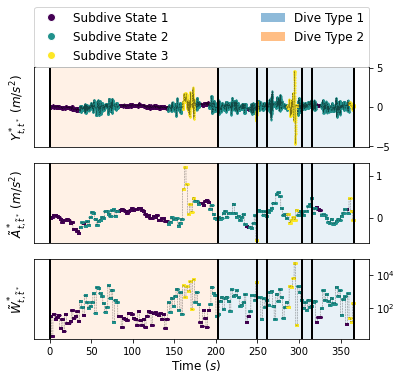

In [36]:
#data = datasets[0]

fig,ax = plt.subplots(3,1,figsize=(6,5))
ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
ax[2].yaxis.tick_right()

plot_col('A',data_test,'subdive',1,ax[0],legend=True,size=12)
#ax[0].set_title('Accelerometer Data, 5 Dives', fontsize = 10)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize = 12)
#ax[0].set_yticks([-1.0,0,1.0])
ax[0].set_xticks([])
for item in ax[0].get_yticklabels():
    item.set_fontsize(10)

plot_col('avg_A',data_test,'subdive',0,ax[1])
ax[1].set_ylabel(r'$\tilde A^*_{t,\tilde t^*}$ $(m/s^2)$', fontsize = 12)
ax[1].set_xticks([])
#ax[1].set_yticks([-0.6,0,0.6])
for item in ax[1].get_yticklabels():
    item.set_fontsize(10)

plot_col('FoVeDBA',data_test,'subdive',0,ax[2])
ax[2].set_ylabel(r'$\tilde{W}^*_{t, \tilde{t}^*}$',fontsize = 12)
ax[2].set_yscale('log')
#ax[2].set_ylim([0,1000])
#ax[2].set_yticks([0,500,1000])
for item in ax[2].get_xticklabels():
    item.set_fontsize(10)
for item in ax[2].get_yticklabels():
    item.set_fontsize(10)
    
fig.text(0.5, 0.04, 'Time ($s$)', ha='center',fontsize=12)

#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
#ax[2].set_rasterized(True)

plt.savefig("../Plots/sim_data.png", bbox_inches='tight', dpi=600)

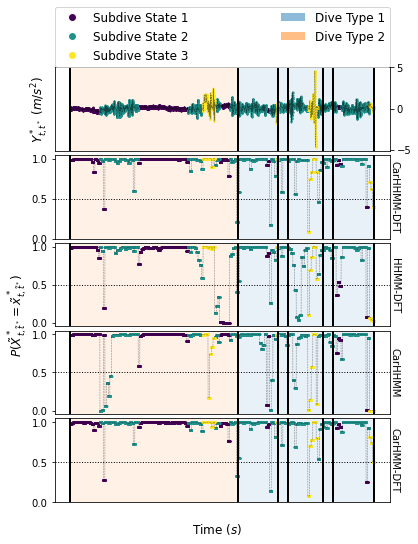

In [38]:
fig,ax = plt.subplots(5,1,figsize=(6,8),sharex=True)
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")
ax[4].yaxis.set_label_position("right")

plot_col('A',data_test,'subdive',1,ax[0],legend=True,size=12)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize=12)
ax[0].set_xticks([])
#ax[0].set_yticks([-1.0,-0.5,0,0.5,1.0])
for item in ax[0].get_yticklabels():
    item.set_fontsize(10)
    
#plt.show()

plot_col('hhmm_FV_subdive',data_test,'subdive',0,ax[1])
ax[1].set_ylabel("CarHHMM-DFT",fontsize=10,rotation=270)
ax[1].set_xticks([])
ax[1].set_yticks([0,0.5,1.0])
ax[1].axhline(0.5,color='k',linestyle=':',linewidth=1)
ax[1].yaxis.set_label_coords(1.03,0.5)
for item in ax[1].get_yticklabels():
    item.set_fontsize(10)

#plt.show()
    
plot_col('hhmm_FV_uncorr_subdive',data_test,'subdive',0,ax[2])
ax[2].set_ylabel("HHMM-DFT",fontsize=10,rotation=270)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1.0])
ax[2].axhline(0.5,color='k',linestyle=':',linewidth=1)
ax[2].yaxis.set_label_coords(1.03,0.5)
for item in ax[2].get_yticklabels():
    item.set_fontsize(10)

#plt.show()

plot_col('hhmm_V_subdive',data_test,'subdive',0,ax[3])
ax[3].set_ylabel("CarHHMM",fontsize=10,rotation=270)
ax[3].set_xticks([])
ax[3].set_yticks([0,0.5,1.0])
ax[3].yaxis.set_label_coords(1.03,0.5)
ax[3].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[3].get_yticklabels():
    item.set_fontsize(10)

#plt.show()
    
plot_col('hmm_FV_subdive',data_test,'subdive',0,ax[4])
ax[4].set_ylabel("CarHMM-DFT",fontsize=10,rotation=270)
ax[4].set_yticks([0,0.5,1.0])
ax[4].yaxis.set_label_coords(1.03,0.5)
ax[4].axhline(0.5,color='k',linestyle=':',linewidth=1)
#ax[4].set_xticks([0,50,100,150,200,250])
for item in ax[4].get_yticklabels():
    item.set_fontsize(10)
for item in ax[4].get_xticklabels():
    item.set_fontsize(10)
    
#plt.show()

#fig.text(0.5, 0.89, 'Decoded Subdive State Probabilities', ha = 'center', fontsize=50)
fig.text(0.5, 0.07, 'Time ($s$)', ha='center',fontsize=12)
fig.text(0.015, 0.45, r'$P(\tilde X^*_{t,\tilde t^*} = \tilde x^*_{t,\tilde t^*})$', 
         va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.05)

#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
#ax[2].set_rasterized(True)
#ax[3].set_rasterized(True)
#ax[4].set_rasterized(True)

plt.savefig('../Plots/Posterior_Fine_States.png',bbox_inches='tight',dpi=600)

In [31]:
hhmm_V.theta

[{'dive_duration': {'mu': array([ 27.54296448, 109.5474679 ]),
   'sig': array([10.26182298, 37.11500697]),
   'corr': array([-10., -10.])}},
 [{'A': {'mu': array([0.03722488, 0.08924389, 0.12303438]),
    'sig': array([0.10817579, 0.28429723, 1.13896686]),
    'corr': array([  1.55051294, -16.88430738, -17.17186508])}},
  {'A': {'mu': array([0.03722488, 0.08924389, 0.12303438]),
    'sig': array([0.10817579, 0.28429723, 1.13896686]),
    'corr': array([  1.55051294, -16.88430738, -17.17186508])}}]]

In [32]:
hhmm_FV.theta

[{'dive_duration': {'mu': array([ 26.03609692, 135.41722086]),
   'sig': array([ 9.49905999, 57.3206187 ]),
   'corr': array([-10., -10.])}},
 [{'FoVeDBA': {'mu': array([  33.53842325,  482.3800136 , 8124.27462405]),
    'sig': array([   22.26071879,   487.0310492 , 11191.88307382]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0.0006967 , 0.08441009, 0.27675927]),
    'sig': array([0.04909569, 0.10277696, 0.28935731]),
    'corr': array([3.48338732, 1.65800467, 0.14509857])}},
  {'FoVeDBA': {'mu': array([  33.53842325,  482.3800136 , 8124.27462405]),
    'sig': array([   22.26071879,   487.0310492 , 11191.88307382]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0.0006967 , 0.08441009, 0.27675927]),
    'sig': array([0.04909569, 0.10277696, 0.28935731]),
    'corr': array([3.48338732, 1.65800467, 0.14509857])}}]]

In [33]:
hhmm_FV_uncorr.theta

[{'dive_duration': {'mu': array([ 27.93299065, 119.71295454]),
   'sig': array([10.60923687, 47.77469457]),
   'corr': array([-10., -10.])}},
 [{'FoVeDBA': {'mu': array([  31.42190427,  450.04548626, 5700.98814963]),
    'sig': array([  21.1671481 ,  478.47852088, 9676.29155349]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0.0093069 , 0.1037199 , 0.14460041]),
    'sig': array([0.11576016, 0.14995531, 0.35484746]),
    'corr': array([-10., -10., -10.])}},
  {'FoVeDBA': {'mu': array([  31.42190427,  450.04548626, 5700.98814963]),
    'sig': array([  21.1671481 ,  478.47852088, 9676.29155349]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0.0093069 , 0.1037199 , 0.14460041]),
    'sig': array([0.11576016, 0.14995531, 0.35484746]),
    'corr': array([-10., -10., -10.])}}]]

In [34]:
hmm_FV.theta

[{'dive_duration': {'mu': array([44.75002385]),
   'sig': array([34.1279174]),
   'corr': array([-10.])}},
 [{'FoVeDBA': {'mu': array([  34.48710598,  504.20632841, 9648.71466813]),
    'sig': array([   22.94333512,   515.59410557, 14000.27195453]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0.00082   , 0.12472762, 0.27402004]),
    'sig': array([0.04900977, 0.09763919, 0.3106482 ]),
    'corr': array([3.68453018, 1.59506088, 0.44039067])}}]]

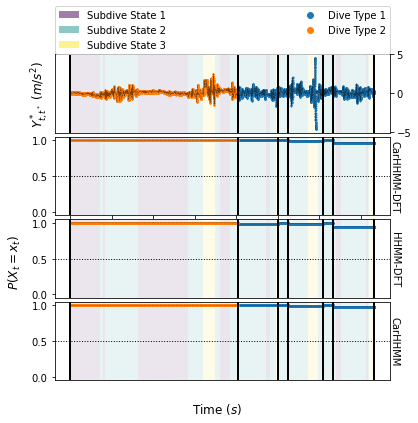

In [37]:
fig,ax = plt.subplots(4,1,figsize=(6,6))
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

plot_col('A',data_test,'dive',1,ax[0],legend=True,size=10)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize=12)
ax[0].set_xticks([])
#ax[0].set_yticks([-1.0,-0.5,0,0.5,1.0])
for item in ax[0].get_yticklabels():
    item.set_fontsize(10)

plot_col('hhmm_FV_dive',data_test,'dive',0,ax[1])
ax[1].set_ylabel("CarHHMM-DFT",fontsize=10,rotation=270)
ax[1].set_ylim([-0.05,1.05])
ax[1].yaxis.set_label_coords(1.03,0.5)
ax[1].set_yticks([0,0.5,1.0])
ax[1].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[1].get_yticklabels():
    item.set_fontsize(10)
    
plot_col('hhmm_FV_uncorr_dive',data_test,'dive',0,ax[2])
ax[2].set_ylabel("HHMM-DFT",fontsize=10,rotation=270)
ax[2].set_ylim([-0.05,1.05])
ax[2].yaxis.set_label_coords(1.03,0.5)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1.0])
ax[2].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[2].get_yticklabels():
    item.set_fontsize(10)


plot_col('hhmm_V_dive',data_test,'dive',0,ax[3])
ax[3].set_ylabel("CarHHMM",fontsize=10,rotation=270)
ax[3].set_ylim([-0.05,1.05])
ax[3].yaxis.set_label_coords(1.03,0.5)
ax[3].set_xticks([])
ax[3].set_yticks([0,0.5,1.0])
ax[3].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[3].get_yticklabels():
    item.set_fontsize(10)
for item in ax[3].get_xticklabels():
    item.set_fontsize(10)

#fig.text(0.5, 0.89, 'Decoded Dive Type Probabilities', ha = 'center', fontsize=12)
fig.text(0.5, 0.05, 'Time ($s$)', ha='center',fontsize=12)
fig.text(0.015, 0.4, '$P(X_t = x_t)$', va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.05)

#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
#ax[2].set_rasterized(True)
#ax[3].set_rasterized(True)

plt.savefig('../Plots/Posterior_Coarse_States.png',bbox_inches='tight',dpi=600)

# Record Standard Errors

In [21]:
'''
if train_new:
    
    h = 0.001
    hmm_FV.get_SEs(data_FV,h)
    hhmm_FV_uncorr.get_SEs(data_FV,h)
    hhmm_V.get_SEs(data_V,h)
    hhmm_FV.get_SEs(data_FV,h)
'''

'\nif train_new:\n    \n    h = 0.001\n    hmm_FV.get_SEs(data_FV,h)\n    hhmm_FV_uncorr.get_SEs(data_FV,h)\n    hhmm_V.get_SEs(data_V,h)\n    hhmm_FV.get_SEs(data_FV,h)\n'

# Make Confusion Matrix on Test data

In [22]:
'''
data,data_V,data_FV = create_data()

### HMM ###

for dive_num,datum in enumerate(data_FV):
    _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    for i,post in enumerate(posts.T):
        data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
        data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hmm_FV_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hmm_FV_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hmm_FV_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hmm_FV_subdive'])
        
hmm_FV.CM = [CM_coarse,CM_fine]
        
### HHMM ###

# crude posterior
_,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_uncorr_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_uncorr_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_FV_uncorr_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_FV_uncorr_subdive'])
        
hhmm_FV_uncorr.CM = [CM_coarse,CM_fine]
        
        
### CarHHMM, no Z2 ###

# crude posterior
_,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

# fine posterior
for dive_num,datum in enumerate(data_V):
    data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        if i%2 == 0:
            p0 = p
        else:
            data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
            data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,1]


# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_V_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_V_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_V_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_V_subdive'])
        
hhmm_V.CM = [CM_coarse,CM_fine]           


    
### CarHHMM ###
            
# crude posterior
_,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]   
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_FV_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_FV_subdive'])
        
hhmm_FV.CM = [CM_coarse,CM_fine]
'''

"\ndata,data_V,data_FV = create_data()\n\n### HMM ###\n\nfor dive_num,datum in enumerate(data_FV):\n    _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])\n    for i,post in enumerate(posts.T):\n        data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0\n        data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]\n        \n# get confusion matrix\nCM_coarse = np.zeros((2,2))\nCM_fine = [np.zeros((2,2)),np.zeros((2,2))]\nfor dive in data:\n    dive_type = dive['dive_type']\n    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hmm_FV_dive']\n    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hmm_FV_dive'])\n    for seg in dive['subdive_features']:\n        subdive_type = seg['subdive_type']\n        CM_fine[dive_type][subdive_type,1] += seg['hmm_FV_subdive']\n        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hmm_FV_subdive'])\n        \nhmm_FV.CM = [CM_coarse,CM_fine]\n        \n### HHMM ###\n\n# crude posterior\n_,_,pos

In [23]:
### CarHMM ###
print(hhmm_FV.theta[0])
print('')
print(hhmm_FV.theta[1])
print('')
print(hhmm_FV.SEs)
print('')
print(hhmm_FV.train_time)
print('')
print(hhmm_FV.CM[0])
print('')
print(hhmm_FV.CM[1])

{'dive_duration': {'mu': array([ 26.03609692, 135.41722086]), 'sig': array([ 9.49905999, 57.3206187 ]), 'corr': array([-10., -10.])}}

[{'FoVeDBA': {'mu': array([  33.53842325,  482.3800136 , 8124.27462405]), 'sig': array([   22.26071879,   487.0310492 , 11191.88307382]), 'corr': array([-10., -10., -10.])}, 'A': {'mu': array([0.0006967 , 0.08441009, 0.27675927]), 'sig': array([0.04909569, 0.10277696, 0.28935731]), 'corr': array([3.48338732, 1.65800467, 0.14509857])}}, {'FoVeDBA': {'mu': array([  33.53842325,  482.3800136 , 8124.27462405]), 'sig': array([   22.26071879,   487.0310492 , 11191.88307382]), 'corr': array([-10., -10., -10.])}, 'A': {'mu': array([0.0006967 , 0.08441009, 0.27675927]), 'sig': array([0.04909569, 0.10277696, 0.28935731]), 'corr': array([3.48338732, 1.65800467, 0.14509857])}}]

{'dive_duration': {'mu': array([ 0.90822675, 16.76488158]), 'sig': array([ 0.71678108, 13.93771878]), 'corr': array([inf, inf])}, 'FoVeDBA': {'mu': array([  0.64518507,   9.65947552, 223.55